In [16]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from random import shuffle

# Data Wrangling

In [17]:
# reading data
DATA = Path('data')
h5 = h5py.File(DATA/'train.h5', 'r')

n = 10000
n_train = int(0.8*n)

train_x = h5['x0'][:n_train]
train_y = h5['targs'][:n_train]
valid_x = h5['x0'][n_train:n]
valid_y = h5['targs'][n_train:n]
h5.close()

# normalize data
data = [train_x, train_y, valid_x, valid_y]
for i, x in enumerate(data):
    x_min = x.min(axis=(1, 2), keepdims=True)
    x_max = x.max(axis=(1, 2), keepdims=True)

    data[i] = (x - x_min)/(x_max-x_min)
    data[i][np.isnan(data[i])] = 0

train_x, train_y, valid_x, valid_y = data

# change train_y and valid_y to be the number of walls
train_y = [float((x == 1).sum()) for x in train_y]
valid_y = [float((x == 1).sum()) for x in valid_y]
print("range of number of walls: " + str((np.min(train_y), np.max(train_y))))

/opt/anaconda3/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


range of number of walls: (4.0, 234.0)


In [98]:
# plotting helper function
def plot_head(data):
    for i in tqdm(range(len(x[0]))):
        sns.heatmap(data[0][i], square=True)
        plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

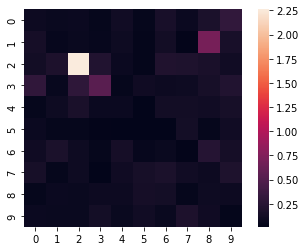

 10%|█         | 1/10 [00:00<00:02,  4.15it/s]

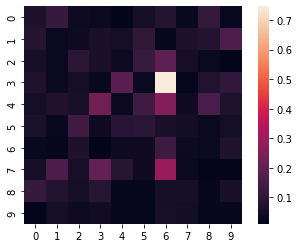

 20%|██        | 2/10 [00:00<00:01,  4.73it/s]

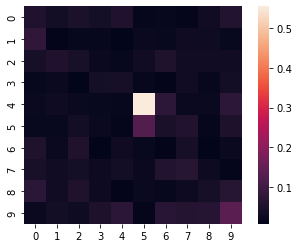

 30%|███       | 3/10 [00:00<00:01,  5.16it/s]

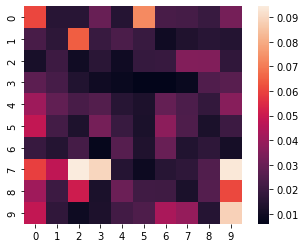

 40%|████      | 4/10 [00:00<00:01,  5.27it/s]

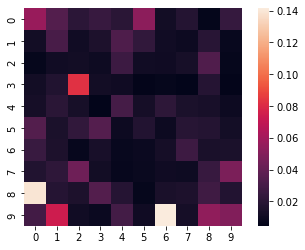

 50%|█████     | 5/10 [00:00<00:00,  5.40it/s]

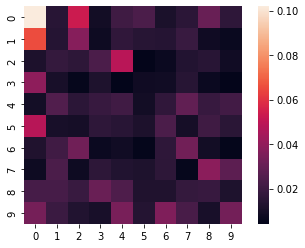

 60%|██████    | 6/10 [00:01<00:00,  5.39it/s]

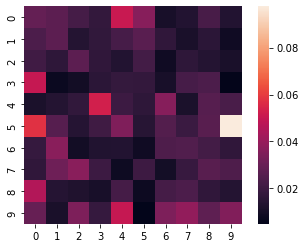

 70%|███████   | 7/10 [00:01<00:00,  5.42it/s]

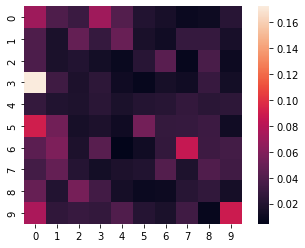

 80%|████████  | 8/10 [00:01<00:00,  5.31it/s]

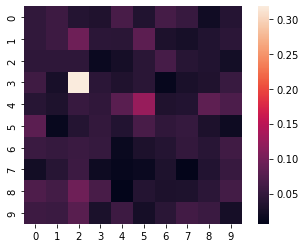

 90%|█████████ | 9/10 [00:01<00:00,  5.27it/s]

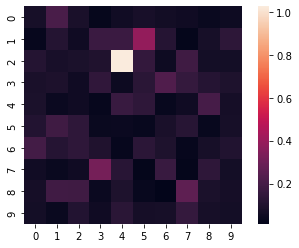

100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


In [28]:
# all 10 layers for the first training dataset X0 sample.
plot_head(train_x)

  0%|          | 0/10 [00:00<?, ?it/s]

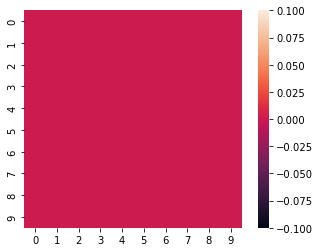

 10%|█         | 1/10 [00:00<00:01,  5.08it/s]

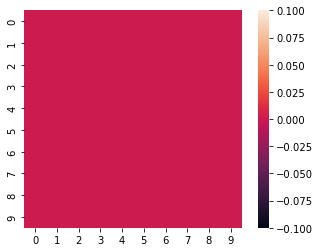

 20%|██        | 2/10 [00:00<00:01,  5.42it/s]

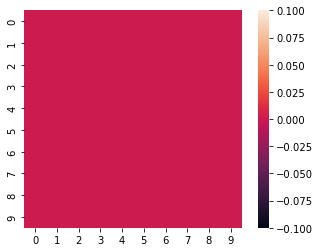

 30%|███       | 3/10 [00:00<00:01,  4.25it/s]

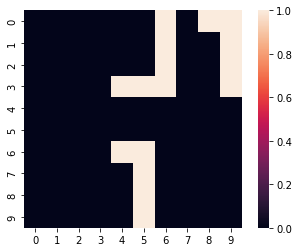

 40%|████      | 4/10 [00:00<00:01,  4.75it/s]

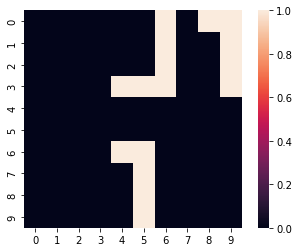

 50%|█████     | 5/10 [00:01<00:00,  5.11it/s]

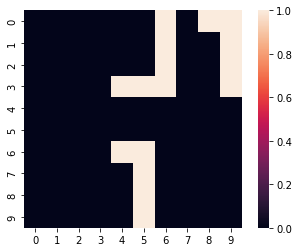

 60%|██████    | 6/10 [00:01<00:00,  5.35it/s]

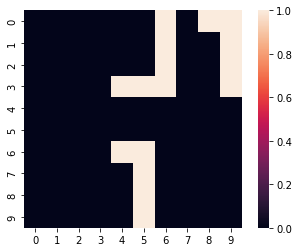

 70%|███████   | 7/10 [00:01<00:00,  5.61it/s]

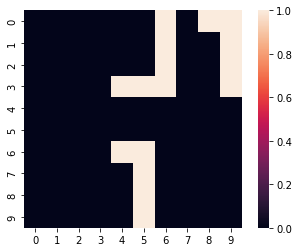

 80%|████████  | 8/10 [00:01<00:00,  5.68it/s]

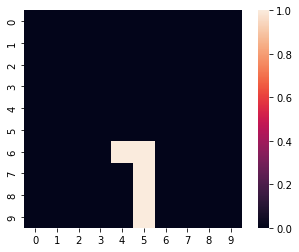

 90%|█████████ | 9/10 [00:01<00:00,  5.76it/s]

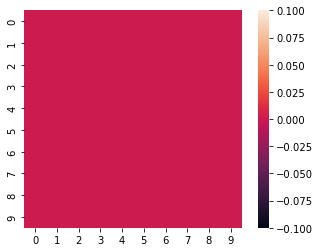

100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


In [32]:
plot_head(train_y)

In [18]:
train_x = torch.tensor(np.array(train_x), requires_grad=True).to(torch.float32)
train_y = torch.tensor(np.array(train_y), requires_grad=True).to(torch.float32)
valid_x = torch.tensor(np.array(valid_x), requires_grad=True).to(torch.float32)
valid_y = torch.tensor(np.array(valid_y), requires_grad=True).to(torch.float32)

In [19]:
train_y

tensor([ 85., 114.,  84.,  ...,  35.,  35.,  50.], grad_fn=<ToCopyBackward0>)

# DNN Implementation

In [124]:
class DNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1000, 784),
            nn.ReLU(),
            nn.Linear(784, 784),
            nn.ReLU(),
            nn.Linear(784, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [125]:
dnn = DNN(num_classes=1) # set number of output classes to 1 for regression
print('DNN model initialized...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ' + str(device))

loss_func = nn.CrossEntropyLoss()
lr = 0.001
print(dnn.parameters())
optimizer = optim.Adam(dnn.parameters(), lr=lr)

num_epochs = 10
batch_size = 64
print('Parameters initialized...')

train_loader = torch.utils.data.DataLoader([[train_x[i], train_y[i]] for i in range(len(train_x) - 1)], shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader([[valid_x[i], valid_y[i]] for i in range(len(valid_x) - 1)], shuffle=True, batch_size=batch_size)
print('Data loaders initialized...')

DNN model initialized...
Device: cpu
<generator object Module.parameters at 0x7fac33c738d0>
Parameters initialized...
Data loaders initialized...


In [127]:
losses=[]
dnn.train()
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        slices, labels = data

        optimizer.zero_grad()

        predictions = dnn(slices).flatten()
        # print(predictions[0])
        # print(labels.shape)
        loss = loss_func(predictions, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        
print('Finished Training')
PATH = '/Users/sean/Documents/Neubauer_Research/mode_diffprog_22_challenge_submission/dnn_model'
torch.save(dnn.state_dict(), PATH)
print('Saved model')

Epoch [1/10], Step [100/125], Loss: 17103.7637
Epoch [2/10], Step [100/125], Loss: 17779.3203
Epoch [3/10], Step [100/125], Loss: 18420.8438
Epoch [4/10], Step [100/125], Loss: 17439.1465
Epoch [5/10], Step [100/125], Loss: 20716.8457
Epoch [6/10], Step [100/125], Loss: 18380.2715
Epoch [7/10], Step [100/125], Loss: 18300.1484
Epoch [8/10], Step [100/125], Loss: 20144.0234
Epoch [9/10], Step [100/125], Loss: 18175.9297
Epoch [10/10], Step [100/125], Loss: 16673.8457
Finished Training
Saved model


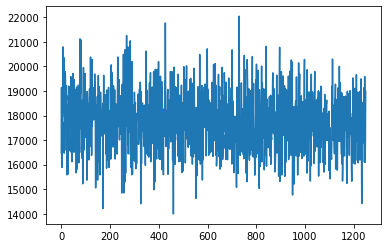

In [128]:
plt.plot(losses)

In [130]:
correct = 0
total = 0

correct_pred = 0
total_pred = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        # print(images.shape)
        prediction = dnn(images)
        # print(prediction[0])
        total += labels.size(0)
        # print(prediction, labels)
        correct += (prediction == labels).sum().item()

print(f'Accuracy for DNN: {100 * correct / total} %')

Accuracy for DNN: 0.0 %


# Multi-CNN Implementation

In [24]:
import modeler

multi_cnn = modeler.MyClassifier().to(device)
print('Multi-CNN model initialized...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ' + str(device))

loss_func = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(multi_cnn.parameters, lr=lr)

num_epochs = 20
batch_size = 64
print('Parameters initialized...')

train_loader = torch.utils.data.DataLoader([[train_x[i], train_y[i]] for i in range(len(train_x) - 1)], shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader([[valid_x[i], valid_y[i]] for i in range(len(valid_x) - 1)], shuffle=True, batch_size=batch_size)
print('Data loaders initialized...')

losses=[]
multi_cnn.train()
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        slices, labels = data
        print(labels)
        optimizer.zero_grad()

        predictions = multi_cnn(slices)
        print(predictions.shape)
        # predictions = torch.tensor([float((prediction == 1).sum()) for prediction in predictions], requires_grad=True).to(torch.float32)
        predictions = torch.tensor([len(prediction[prediction > .5]) for prediction in predictions]).to(torch.float32)
        print(predictions.shape)
        labels = labels.to(torch.float32)
        loss = loss_func(predictions, labels)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        
print('Finished Training')
PATH = '/Users/sean/Documents/Neubauer_Research/mode_diffprog_22_challenge_submission/mulit_cnn_model'
torch.save(multi_cnn.state_dict(), PATH)
print('Saved model')

Multi-CNN model initialized...
Device: cpu
Parameters initialized...
Data loaders initialized...
tensor([115., 140.,  46.,  50.,  81.,  58., 129., 157.,  45., 102.,  24.,  34.,
         48., 107.,  35.,  44.,  42., 144., 109.,  69.,  78., 141.,  42.,  66.,
        105., 112.,   8.,  80., 101.,  25.,  95.,  72.,  79.,  98.,  80.,  92.,
         52., 135.,  64.,  50.,  28.,  72.,  28.,  97.,  70.,  85., 127., 119.,
        113.,  60.,  40.,  93.,  68.,  80.,  18.,  63., 101., 128.,  66.,  15.,
         42.,  84.,  83.,  38.], grad_fn=<StackBackward0>)
torch.Size([64, 10, 10, 10])
torch.Size([64])


RuntimeError: all elements of input should be between 0 and 1

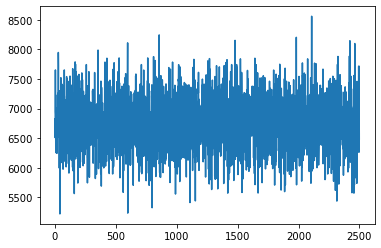

In [5]:
plt.plot(losses)